# Case Study - Nonsense Questions

The goal of this notebook is to build a classifier that identifies normal vs nonsense questions, as well as analyze it's accuracy.  Basically answering the question "does this question make sense".

1. Imports and functions
2. Simple attempt
3. Conclusion

This notebook is a re-run of the original notebook that used text-davinci-002 model.  Now we use text-davinci-003 and compare results. We expect to see improvements.

## 1. Imports and functions

In [1]:
import re
import os
import openai
from time import time, sleep
import textwrap
import pandas as pd

In [2]:
def open_file(filepath):
    with open(filepath, 'r', encoding='utf-8') as infile:
        return infile.read()


def save_file(filepath, content):
    with open(filepath, 'w', encoding='utf-8') as outfile:
        outfile.write(content)

# change path to where you store your credentials
openai.api_key = open_file('../../creds/creds.txt')


def gpt3_completion(prompt, label='gpt3', engine='text-davinci-003', temp=0.99, top_p=1.0, tokens=400, freq_pen=2.0, pres_pen=2.0, stop=['asdfasdf', 'asdasdf']):
    max_retry = 5
    retry = 0
    prompt = prompt.encode(encoding='ASCII', errors='ignore').decode()  # force it to fix any unicode errors
    while True:
        try:
            response = openai.Completion.create(
                engine=engine,
                prompt=prompt,
                temperature=temp,
                max_tokens=tokens,
                top_p=top_p,
                frequency_penalty=freq_pen,
                presence_penalty=pres_pen,
                stop=stop)
            text = response['choices'][0]['text'].strip()
            text = re.sub('\s+', ' ', text)
            return text
        except Exception as oops:
            retry += 1
            if retry >= max_retry:
                return "GPT3 error: %s" % oops
            print('Error communicating with OpenAI:', oops)
            sleep(1)


In [3]:
df_nonsense = pd.read_csv('nonsense_questions.csv')

In [4]:
# validation column shows if it actually makes sense to ask the question
df_nonsense

,question_number,question,validation
0,1,What is the hamburger made of?,Yes
1,2,Is the hamburger a frog on mog?,No
2,3,Will the stock market go up?,Yes
3,4,Will the stock market by groceries?,No
4,5,When did she fly the airplane?,Yes
5,6,When did she fly the bee?,No
6,7,Why is the leaf green?,Yes
7,8,Why is the leaf angry?,No
8,9,Where are rainbows formed?,Yes
9,10,Where are rainbows graduating from college?,No


## 2. Simple attempt

We will use the following template for the prompt

In the following text we have a question. Does this question make sense? i.e If the question is "normal" answer with "Yes" and if the question is "nonsense" answer "No".

QUESTION:

question_from_dataframe


Does the question make sense, "Yes" or "No" answer:

In [5]:
prompt_beginning = """In the following text we have a question. Does this question make sense? i.e If the question is "normal" answer with "Yes" and if the question is "nonsense" answer "No"."""
nl_str = """\n\n"""
question_str = """QUESTION:\n"""
final_answer_str = """Does the question make sense, "Yes" or "No" answer:"""


We will iterate over temperature to see if it changes much

In [6]:
temp_list = [0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 1]

In [ ]:
score_list = []
for temp in temp_list:
    gpt_cot_list = []
    print(temp)
    for row in df_nonsense.iterrows():
        question = row[1]['question']
        prompt = prompt_beginning + nl_str + question_str + question + nl_str + final_answer_str
        #print(prompt)
        final_answer = gpt3_completion(prompt, temp = temp)
        #print(final_answer)
        if final_answer not in ['Yes','No']:
            prompt_init = """Condense the following sentence into a simple "Yes" or "No" answer"""
            prompt = prompt_init + nl_str + final_answer + nl_str + """ "Yes" or "No" output: """
            final_a = gpt3_completion(prompt)
            final_a.replace('.','').replace(' ','')
            final_answer = final_a
        final_answer.replace('.','').replace(' ','')
        print(row[0])
        gpt_cot_list.append(final_answer)
    col_string = 'CoT_'+ str(temp)
    df_nonsense[col_string] = gpt_cot_list
    score = sum(gpt_cot_list == df_nonsense['validation'])/21
    score_list.append(score) 


In [25]:
df_nonsense

,question_number,question,validation,CoT_0.2,CoT_0.4,CoT_0.6,CoT_0.8,CoT_0.9,CoT_0.95,CoT_1
0,1,What is the hamburger made of?,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes
1,2,Is the hamburger a frog on mog?,No,No,No,No,No,No,No,No
2,3,Will the stock market go up?,Yes,No,Yes,No,No,Yes,No,No
3,4,Will the stock market by groceries?,No,No,No,No,No,No,No,No
4,5,When did she fly the airplane?,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes
5,6,When did she fly the bee?,No,No,No,No,No,No,No,No
6,7,Why is the leaf green?,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes
7,8,Why is the leaf angry?,No,No,No,No,No,No,No,No
8,9,Where are rainbows formed?,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes
9,10,Where are rainbows graduating from college?,No,No,No,No,No,No,No,No


In [8]:
df_results = pd.DataFrame(list(zip(temp_list, score_list)), columns =['Temp', 'Score'])
df_results


,Temp,Score
0,0.20,1.0
1,0.40,1.0
2,0.60,1.0
3,0.80,1.0
4,0.90,1.0
5,0.95,1.0
6,1.00,1.0


Perfect scores. This outperforms the 002 model by a lot. Below you can see the scores for the experiment I did with text-davinci-002:


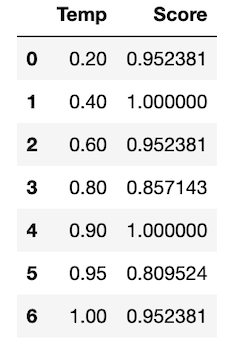

In [24]:
from IPython.display import Image
Image("img/nonsense_1.png", width= 150)

## 3. Conclusion

text-davinci-003 is a big improvement already, and this function is now looking quite reliable.  Let's just note that we could further complicate the dataset questions (and increase dataset size) to better understand the potential blindspots, but I have no plans currently to try that out.